# CBAM: Convolutional Block Attention Module
### Módulo de bloque de atención convolucional

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deep_learning/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/deep_learning/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wro

![](channel_att.png)

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

![](spatial_att.png)

In [3]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

![](cbam.png)

In [4]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        # Store the input for visualization if needed
        self.input = x.detach()
        
        # Channel attention
        channel_att = self.channel_attention(x)
        x = x * channel_att
        self.after_channel = x.detach()
        
        # Spatial attention
        spatial_att = self.spatial_attention(x)
        x = x * spatial_att
        
        # Store attention maps for visualization
        self.channel_att_map = channel_att.detach()
        self.spatial_att_map = spatial_att.detach()
        
        return x

![](block.png)

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.cbam = CBAM(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        
        out = self.cbam(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

In [6]:
class CBAM_CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.2):
        super(CBAM_CNN, self).__init__()
        
        # Initialize attention_blocks as a ModuleList
        self.attention_blocks = nn.ModuleList()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Layers
        self.layer1 = self._make_layer(64, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(64, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(128, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(256, 512, 2, stride=2, dropout_rate=dropout_rate)
        
        # Global Average Pooling and classifier
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride, dropout_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            block = BasicBlock(in_channels, out_channels, stride, dropout_rate)
            layers.append(block)
            in_channels = out_channels
            self.attention_blocks.append(block.cbam)
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout_fc(out)
        out = self.fc(out)
        
        return out
    
    def get_attention_maps(self):
        """
        Returns a list of attention maps from all CBAM modules
        """
        attention_maps = []
        for block in self.attention_blocks:
            # For each CBAM block, get the channel and spatial attention maps
            spatial_att = block.spatial_att_map
            channel_att = block.channel_att_map
            attention_maps.append({
                'spatial': spatial_att, 
                'channel': channel_att,
                'input': block.input,
                'after_channel': block.after_channel
            })
        return attention_maps 

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Mac Silicon) device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS (Mac Silicon) device


In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

model = CBAM_CNN().to(device)
model.load_state_dict(torch.load('cbam_cifar10.pth', map_location=device))
model.eval()

/var/folders/zg/nx5dksqx7cl_bs_pvngf8_zm0000gn/T/ipykernel_83755/2564187190.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cbam_cifar1

CBAM_CNN(
  (attention_blocks): ModuleList(
    (0-1): 2 x CBAM(
      (channel_attention): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): ReLU()
          (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (sigmoid): Sigmoid()
      )
      (spatial_attention): SpatialAttention(
        (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (sigmoid): Sigmoid()
      )
    )
    (2-3): 2 x CBAM(
      (channel_attention): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): ReLU()
          (2): Conv2d(8, 128, kernel_size=(1, 1), stride=(1,

![](plot_accs_val_loss.png)

In [9]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                           transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, 
                                         shuffle=True)

Files already downloaded and verified


In [10]:
def calculate_accuracy(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = 0
    
    with torch.no_grad():  # No necesitamos calcular gradientes
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Calcular y mostrar el accuracy
accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy en el test set: {accuracy:.2f}%')

Accuracy en el test set: 90.87%


In [23]:
from PIL import Image
from torchcam.methods import GradCAM

In [28]:
def get_grad_cam(model, inputs):
    # Mover los inputs al mismo dispositivo que el modelo
    device = next(model.parameters()).device
    inputs = inputs.to(device)
    
    # Crear el extractor GradCAM
    cam_extractor = GradCAM(model, target_layer='layer4')
    
    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    # Obtener el mapa de atención
    cams = cam_extractor(outputs.squeeze(0).argmax().item(), outputs)
    
    # Normalizar la imagen de entrada (deshaciendo la normalización de CIFAR-10)
    img = inputs.squeeze().cpu()
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    # Obtener y normalizar el mapa de calor
    heatmap = cams[0].squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    # Redimensionar el heatmap al tamaño de la imagen (32x32)
    heatmap = cv2.resize(heatmap, (32, 32))
    
    # Convertir heatmap a formato de color
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = np.float32(heatmap_colored) / 255.0
    
    # Superponer el heatmap en la imagen
    cam = heatmap_colored + np.float32(img)
    cam = cam / np.max(cam)
    
    return img, heatmap, cam, preds.item()

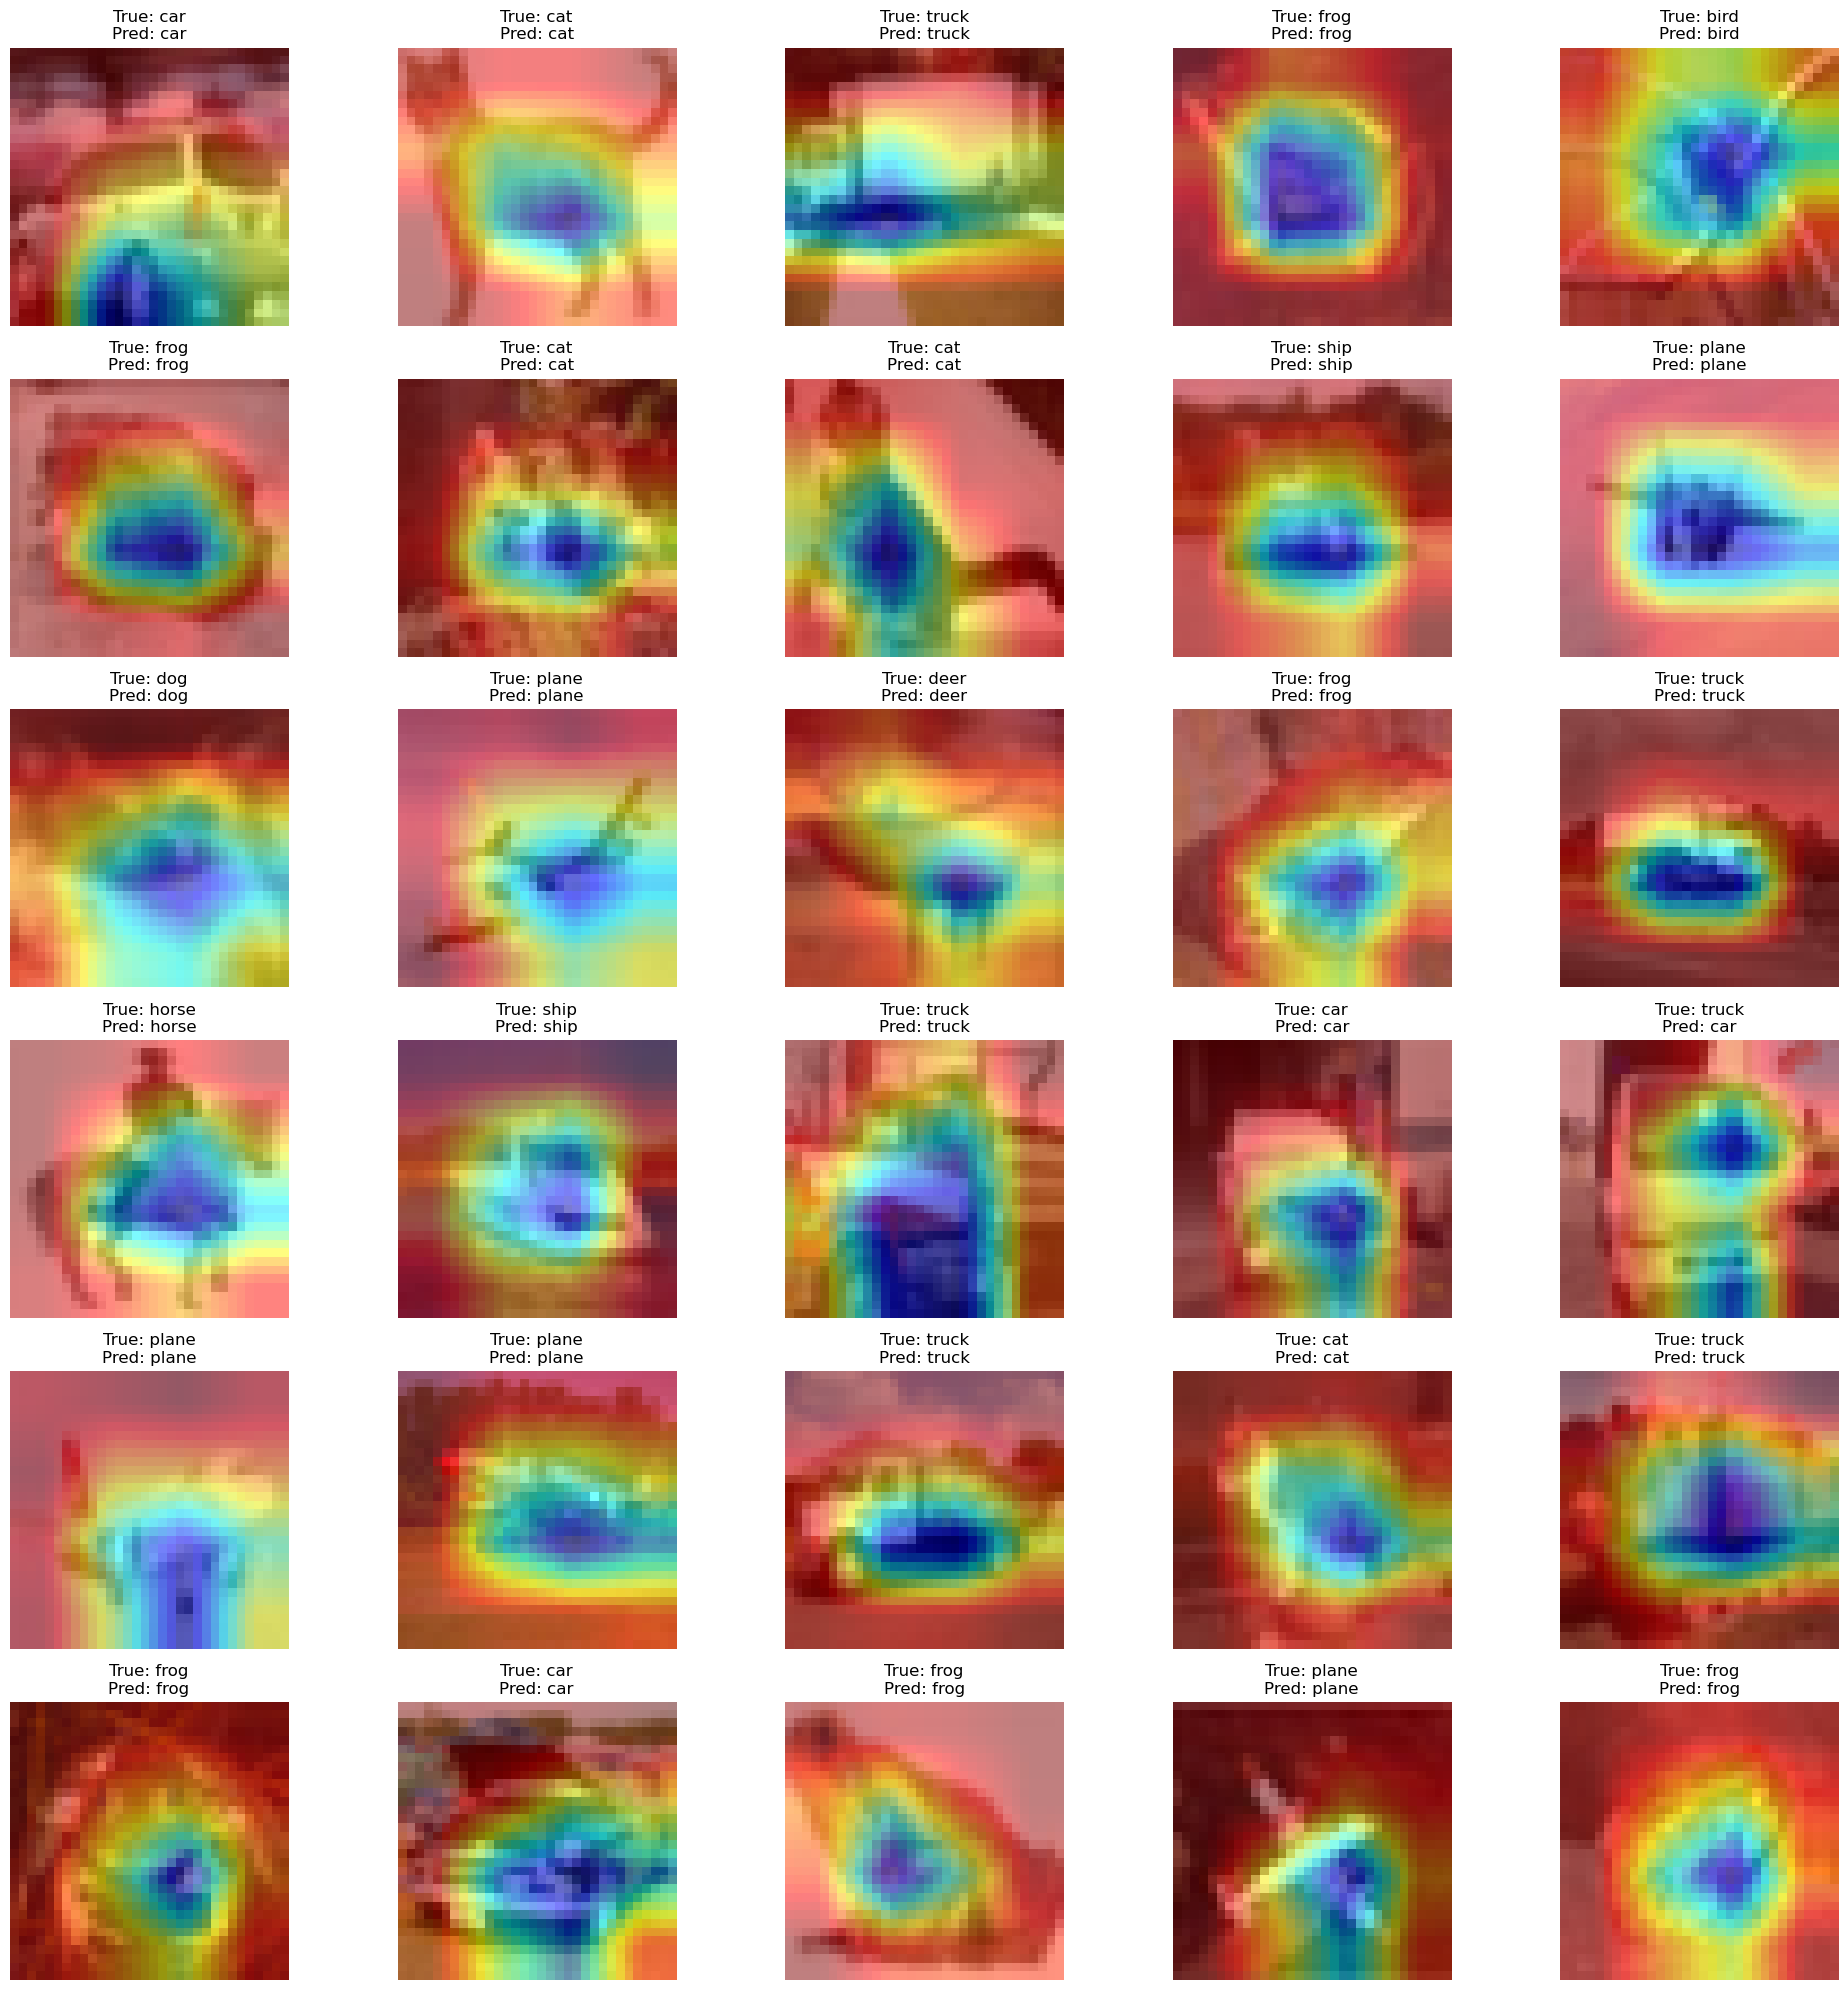

In [31]:
num_images = 30
images_so_far = 0

# Get a batch of test images
dataiter = iter(test_loader)

plt.figure(figsize=(20, 20))  # Aumenta el tamaño para más imágenes

while images_so_far < num_images:
    inputs, labels = next(dataiter)
    
    img, heatmap, cam, pred_class = get_grad_cam(model, inputs)
    
    ax = plt.subplot(num_images // 5, 5, images_so_far + 1)
    plt.imshow(cam)
    plt.title(f'True: {classes[labels.item()]}\nPred: {classes[pred_class]}')
    plt.axis('off')
    
    images_so_far += 1

plt.tight_layout()
plt.savefig('attention_visualization.png')
plt.show()